# Predicting Duration Ride - NY Taxi Data (Jan and Feb)

In [1]:
# Import libraries
import pandas as pd
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from datetime import datetime
from lightgbm import LGBMRegressor, early_stopping 
import lightgbm
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope

## Setup mlflow

In [2]:
import mlflow
from mlflow.models.signature import infer_signature
from mlflow import MlflowClient
from mlflow.entities import ViewType

In [3]:
MLFLOW_TRAKCING_URI = 'sqlite:///mlflow.db'

In [4]:
# Create client in order to communicate with mlflow
client = MlflowClient(tracking_uri=MLFLOW_TRAKCING_URI)

In [7]:
# Create experiment
# client.create_experiment(name='ny_taxi_ride_prediction')

'3'

In [8]:
mlflow.set_tracking_uri(MLFLOW_TRAKCING_URI)
mlflow.set_experiment('ny_taxi_ride_prediction')

<Experiment: artifact_location='/home/mvoss/default_modeling_script/mlruns/3', creation_time=1715858222424, experiment_id='3', last_update_time=1715858222424, lifecycle_stage='active', name='ny_taxi_ride_prediction', tags={}>

## Read in Data

In [9]:
# Get data
df_rides_jan = pd.read_parquet('data/yellow_tripdata_2024-01.parquet')
df_rides_feb = pd.read_parquet('data/yellow_tripdata_2024-02.parquet')

In [10]:
# Inspect data
df_rides_jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [11]:
# Combine the data
df_rides = pd.concat([df_rides_jan, df_rides_feb], axis=0)

# Check the shape
df_rides.shape

(5972150, 19)

In [12]:
# Check data types
df_rides.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [13]:
# Check for NAs by column
df_rides.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          325772
trip_distance                 0
RatecodeID               325772
store_and_fwd_flag       325772
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     325772
Airport_fee              325772
dtype: int64

## Preprocessing

In [14]:
# Drop NA rows
df_rides = df_rides[~df_rides['passenger_count'].isna()]

In [15]:
# Drop certain variable not needed for modeling
df_rides = df_rides.drop(columns=['store_and_fwd_flag', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'])

In [16]:
# Create pick up time variables
df_rides['hour_of_day'] = df_rides['tpep_pickup_datetime'].dt.hour
df_rides['day_of_week'] = df_rides['tpep_pickup_datetime'].dt.dayofweek
df_rides['month_of_year'] = df_rides['tpep_pickup_datetime'].dt.dayofweek

In [17]:
# Prepare outcome variable
df_rides['ride_duration'] = df_rides['tpep_dropoff_datetime'] - df_rides['tpep_pickup_datetime']

# Convert to unix duration
df_rides['ride_duration'] = df_rides['ride_duration'].dt.total_seconds().astype(int)

# Transform outcome variable
df_rides = df_rides[(df_rides['ride_duration'] > 0) & (df_rides['ride_duration'] < 10000)]
df_rides['ride_duration'] = df_rides['ride_duration'] / 60

In [18]:
# Drop timestamps
df_rides = df_rides.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [19]:
# Check columns
df_rides.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'tip_amount', 'tolls_amount', 'total_amount', 'Airport_fee',
       'hour_of_day', 'day_of_week', 'month_of_year', 'ride_duration'],
      dtype='object')

In [20]:
# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(df_rides.drop(columns=['ride_duration']), df_rides['ride_duration'], test_size=0.2, random_state=42)

In [21]:
mlflow.start_run()

<ActiveRun: >

In [20]:
# Define Preprocessing Steps
mlflow.set_tag('model', 'lightgbm')
mlflow.set_tag('user', 'mvoss')

categorical_features = ['RatecodeID', 'payment_type', 'day_of_week', 'month_of_year', 'hour_of_day', 'PULocationID', 'DOLocationID',]

mlflow.log_param("categorical_features", categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="passthrough" 
)

# Build the Pipeline:
steps = [
    ("preprocessor", preprocessor),
    ("lgbm", LGBMRegressor(objective='regression', random_state=42, force_col_wise=True)),
]
pipeline = Pipeline(steps)

mlflow.log_param("pipeline", pipeline)

# Hyperparameter Tuning (Optional):
# parameters = { 
#     'lgbm__boosting_type': ['gbdt'],
#     'lgbm__num_leaves': [10, 20, 30],
#     'lgbm__max_depth': [-1, 10, 20],
#     'lgbm__learning_rate': [0.01, 0.001, 0.0001],
#     'lgbm__n_estimators': [200, 300, 400],
# }

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['RatecodeID', 'payment_type',
                                                   'day_of_week',
                                                   'month_of_year',
                                                   'hour_of_day',
                                                   'PULocationID',
                                                   'DOLocationID'])])),
                ('lgbm',
                 LGBMRegressor(force_col_wise=True, objective='regression',
                               random_state=42))])

## Modeling

In [21]:
# Set up the grid search object (Optional - in combination with hyperparameters)
# grid_search = GridSearchCV(pipeline, parameters, cv=2, verbose=1, n_jobs=None, scoring='r2')

In [22]:
# Fit to the training data
# grid_search.fit(X_train, y_train)
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 2250
[LightGBM] [Info] Number of data points in the train set: 4512680, number of used features: 551
[LightGBM] [Info] Start training from score 14.963617


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['RatecodeID', 'payment_type',
                                                   'day_of_week',
                                                   'month_of_year',
                                                   'hour_of_day',
                                                   'PULocationID',
                                                   'DOLocationID'])])),
                ('lgbm',
                 LGBMRegressor(force_col_wise=True, objective='regression',
                               random_state=42))])

In [23]:
# Get the best parameters from the grid search
# best_params = grid_search.best_params_
# print(best_params)

In [22]:
def evaluate(y, pred):
    mae = mean_absolute_error(y, pred)
    rmse = root_mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    
    return mae, rmse, r2   

In [25]:
y_pred = pipeline.predict(X_test)

In [26]:
mae, rmse, r2 = evaluate(y_test.values, y_pred)

mlflow.log_metric("MAE", mae)
mlflow.log_metric("RMSE", rmse)
mlflow.log_metric("R2", r2)

In [27]:
print('Mean Absolue Error:', mae)
print('Root Mean Squared Error:', rmse)
print('R2-Score:', r2)

Mean Absolue Error: 1.3846788697822716
Root Mean Squared Error: 3.3518087306591053
R2-Score: 0.9236072478660837


In [23]:
mlflow.end_run()

## Model - Hyperparamter Tuning no GridSearch

In [24]:
# ALTERNATIVELY - Auto log all MLflow entities
# mlflow.lightgbm.autolog()

In [25]:
# Objective Function
def objective(params):
    # alternatively use mlflow.lightgbm.autolog() instead of with mlflow.....
    with mlflow.start_run(nested=True):
        
        mlflow.set_tag('model', 'lightgbm')
        mlflow.set_tag('user', 'mvoss')
        
        mlflow.log_params(params)
        model = LGBMRegressor(**params, random_state=42, verbose=-1)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[early_stopping(stopping_rounds=5, min_delta=0.5)])
        
        # Log model as artifact
        mlflow.lightgbm.log_model(model, artifact_path="models")

        # Get performance KPIs
        y_pred = model.predict(X_test)
        
        mae, rmse, r2 = evaluate(y_test.values, y_pred)
        
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)
        
        # print('Mean Absolue Error:', mae)
        # print('Root Mean Squared Error:', rmse)
        # print('R2-Score:', r2) 
    
    return {'loss': rmse, 'status': STATUS_OK}
        

In [26]:
parameters = { 
    'boosting_type': 'gbdt',
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 30, 1)),   # Finer steps
    'max_depth': scope.int(hp.quniform('max_depth', 2, 20, 2)),      # Smaller range
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 50)), # Finer steps
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 5, 100, 1)),
    'subsample': hp.uniform('subsample', 0.7, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
}

trials=Trials()

best_result = fmin(
    fn=objective,
    space=parameters,
    algo=tpe.suggest,
    max_evals=100,  # Limit evaluations
    trials=trials,
)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:                     
[63]	valid_0's l2: 19.4751
Training until validation scores don't improve for 5 rounds                      
Early stopping, best iteration is:                                               
[39]	valid_0's l2: 23.8439
  2%|▏         | 2/100 [00:07<05:32,  3.39s/trial, best loss: 4.4130594302843935]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                      
Early stopping, best iteration is:                                               
[19]	valid_0's l2: 12.9506
  3%|▎         | 3/100 [00:09<05:04,  3.14s/trial, best loss: 3.5986880597047612]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                      
Early stopping, best iteration is:                                               
[27]	valid_0's l2: 13.153
  4%|▍         | 4/100 [00:13<05:04,  3.17s/trial, best loss: 3.5986880597047612]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                      
Early stopping, best iteration is:                                               
[29]	valid_0's l2: 13.5535
  5%|▌         | 5/100 [00:16<04:55,  3.11s/trial, best loss: 3.5986880597047612]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                      
Early stopping, best iteration is:                                               
[31]	valid_0's l2: 14.0657
  6%|▌         | 6/100 [00:19<04:56,  3.15s/trial, best loss: 3.5986880597047612]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                      
Early stopping, best iteration is:                                               
[19]	valid_0's l2: 12.2983
  7%|▋         | 7/100 [00:22<04:39,  3.01s/trial, best loss: 3.506899428547291] 

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                     
Early stopping, best iteration is:                                              
[55]	valid_0's l2: 16.5
  7%|▋         | 7/100 [00:25<04:39,  3.01s/trial, best loss: 3.506899428547291]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                     
Early stopping, best iteration is:                                              
[41]	valid_0's l2: 13.7229
  8%|▊         | 8/100 [00:28<05:01,  3.28s/trial, best loss: 3.506899428547291]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                     
Early stopping, best iteration is:                                              
[61]	valid_0's l2: 17.8765
  9%|▉         | 9/100 [00:33<05:17,  3.49s/trial, best loss: 3.506899428547291]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                      
Early stopping, best iteration is:                                               
[18]	valid_0's l2: 13.2065
 11%|█         | 11/100 [00:37<05:11,  3.50s/trial, best loss: 3.506899428547291]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                      
Early stopping, best iteration is:                                               
[25]	valid_0's l2: 13.832
 12%|█▏        | 12/100 [00:40<04:58,  3.40s/trial, best loss: 3.506899428547291]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                      
Early stopping, best iteration is:                                               
[21]	valid_0's l2: 12.2877
 13%|█▎        | 13/100 [00:43<04:51,  3.35s/trial, best loss: 3.5053798024928207]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[55]	valid_0's l2: 20.365
 14%|█▍        | 14/100 [00:46<04:40,  3.26s/trial, best loss: 3.5053798024928207]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[17]	valid_0's l2: 12.6724
 15%|█▌        | 15/100 [00:49<04:27,  3.14s/trial, best loss: 3.5053798024928207]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[18]	valid_0's l2: 12.3133
 16%|█▌        | 16/100 [00:52<04:16,  3.06s/trial, best loss: 3.5053798024928207]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[20]	valid_0's l2: 12.0887
 17%|█▋        | 17/100 [00:55<04:12,  3.04s/trial, best loss: 3.4768739882585122]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[48]	valid_0's l2: 14.5353
 17%|█▋        | 17/100 [00:58<04:12,  3.04s/trial, best loss: 3.4768739882585122]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[47]	valid_0's l2: 16.7174
 19%|█▉        | 19/100 [01:03<04:47,  3.55s/trial, best loss: 3.4768739882585122]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[21]	valid_0's l2: 15.1066
 20%|██        | 20/100 [01:06<04:22,  3.28s/trial, best loss: 3.4768739882585122]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[27]	valid_0's l2: 12.4752
 21%|██        | 21/100 [01:09<04:18,  3.27s/trial, best loss: 3.4768739882585122]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[31]	valid_0's l2: 14.4822
 22%|██▏       | 22/100 [01:13<04:25,  3.41s/trial, best loss: 3.4768739882585122]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[24]	valid_0's l2: 12.822
 23%|██▎       | 23/100 [01:16<04:14,  3.31s/trial, best loss: 3.4768739882585122]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[22]	valid_0's l2: 12.7579
 24%|██▍       | 24/100 [01:19<04:03,  3.20s/trial, best loss: 3.4768739882585122]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[39]	valid_0's l2: 14.618
 24%|██▍       | 24/100 [01:22<04:03,  3.20s/trial, best loss: 3.4768739882585122]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[24]	valid_0's l2: 11.8006
 26%|██▌       | 26/100 [01:25<04:00,  3.25s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[26]	valid_0's l2: 13.8678
 27%|██▋       | 27/100 [01:28<03:51,  3.17s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[19]	valid_0's l2: 12.2704
 28%|██▊       | 28/100 [01:31<03:42,  3.09s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[27]	valid_0's l2: 12.7042
 29%|██▉       | 29/100 [01:34<03:38,  3.08s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[15]	valid_0's l2: 12.8671
 30%|███       | 30/100 [01:37<03:30,  3.00s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[24]	valid_0's l2: 12.9518
 31%|███       | 31/100 [01:40<03:32,  3.07s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[20]	valid_0's l2: 12.6298
 32%|███▏      | 32/100 [01:44<03:34,  3.16s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[27]	valid_0's l2: 12.5045
 33%|███▎      | 33/100 [01:47<03:28,  3.11s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[28]	valid_0's l2: 13.0928
 33%|███▎      | 33/100 [01:49<03:28,  3.11s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[30]	valid_0's l2: 13.8013
 35%|███▌      | 35/100 [01:54<03:32,  3.27s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[34]	valid_0's l2: 13.8964
 36%|███▌      | 36/100 [01:57<03:33,  3.34s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[17]	valid_0's l2: 12.5772
 37%|███▋      | 37/100 [02:00<03:18,  3.15s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[24]	valid_0's l2: 12.596
 38%|███▊      | 38/100 [02:03<03:13,  3.12s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[24]	valid_0's l2: 13.17
 39%|███▉      | 39/100 [02:06<03:08,  3.09s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[17]	valid_0's l2: 11.9653
 40%|████      | 40/100 [02:09<03:03,  3.06s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[34]	valid_0's l2: 13.4765
 41%|████      | 41/100 [02:13<03:20,  3.40s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[31]	valid_0's l2: 12.4057
 42%|████▏     | 42/100 [02:17<03:19,  3.43s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[23]	valid_0's l2: 12.1986
 43%|████▎     | 43/100 [02:20<03:12,  3.37s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[23]	valid_0's l2: 12.9456
 44%|████▍     | 44/100 [02:23<03:00,  3.21s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[17]	valid_0's l2: 12.5994
 45%|████▌     | 45/100 [02:25<02:46,  3.03s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[22]	valid_0's l2: 12.2451
 45%|████▌     | 45/100 [02:27<02:46,  3.03s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[49]	valid_0's l2: 19.3964
 47%|████▋     | 47/100 [02:31<02:36,  2.96s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[19]	valid_0's l2: 12.1092
 48%|████▊     | 48/100 [02:34<02:33,  2.95s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[58]	valid_0's l2: 14.6978
 48%|████▊     | 48/100 [02:38<02:33,  2.95s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[34]	valid_0's l2: 15.2208
 50%|█████     | 50/100 [02:43<03:00,  3.61s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[28]	valid_0's l2: 13.1605
 51%|█████     | 51/100 [02:46<02:53,  3.54s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[31]	valid_0's l2: 13.198
 52%|█████▏    | 52/100 [02:49<02:45,  3.46s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[15]	valid_0's l2: 12.4667
 53%|█████▎    | 53/100 [02:52<02:30,  3.19s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[29]	valid_0's l2: 12.783
 54%|█████▍    | 54/100 [02:55<02:29,  3.24s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[39]	valid_0's l2: 13.9079
 54%|█████▍    | 54/100 [02:58<02:29,  3.24s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[24]	valid_0's l2: 12.4389
 56%|█████▌    | 56/100 [03:02<02:27,  3.35s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[21]	valid_0's l2: 13.3215
 57%|█████▋    | 57/100 [03:05<02:17,  3.21s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[19]	valid_0's l2: 12.9877
 58%|█████▊    | 58/100 [03:08<02:09,  3.07s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[21]	valid_0's l2: 13.1223
 59%|█████▉    | 59/100 [03:11<02:06,  3.08s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[35]	valid_0's l2: 15.227
 60%|██████    | 60/100 [03:15<02:08,  3.21s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[51]	valid_0's l2: 15.5231
 60%|██████    | 60/100 [03:17<02:08,  3.21s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[51]	valid_0's l2: 16.5132
 61%|██████    | 61/100 [03:22<02:09,  3.31s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[26]	valid_0's l2: 12.4159
 63%|██████▎   | 63/100 [03:26<02:10,  3.53s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[51]	valid_0's l2: 13.8576
 63%|██████▎   | 63/100 [03:29<02:10,  3.53s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[23]	valid_0's l2: 12.3495
 65%|██████▌   | 65/100 [03:34<02:06,  3.61s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[20]	valid_0's l2: 12.0923
 66%|██████▌   | 66/100 [03:37<01:56,  3.43s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[17]	valid_0's l2: 12.3866
 67%|██████▋   | 67/100 [03:40<01:49,  3.33s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[21]	valid_0's l2: 12.0363
 68%|██████▊   | 68/100 [03:43<01:48,  3.40s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[19]	valid_0's l2: 12.7694
 69%|██████▉   | 69/100 [03:46<01:40,  3.25s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[21]	valid_0's l2: 12.4807
 70%|███████   | 70/100 [03:49<01:37,  3.24s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[29]	valid_0's l2: 12.326
 70%|███████   | 70/100 [03:52<01:37,  3.24s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[19]	valid_0's l2: 12.2592
 72%|███████▏  | 72/100 [03:56<01:30,  3.23s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[17]	valid_0's l2: 12.9714
 73%|███████▎  | 73/100 [03:59<01:24,  3.11s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[25]	valid_0's l2: 12.5863
 74%|███████▍  | 74/100 [04:02<01:21,  3.14s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[23]	valid_0's l2: 12.8122
 75%|███████▌  | 75/100 [04:05<01:21,  3.25s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[24]	valid_0's l2: 12.5028
 76%|███████▌  | 76/100 [04:09<01:18,  3.25s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[25]	valid_0's l2: 14.424
 77%|███████▋  | 77/100 [04:12<01:14,  3.24s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[21]	valid_0's l2: 11.8797
 78%|███████▊  | 78/100 [04:15<01:12,  3.28s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[18]	valid_0's l2: 12.6872
 79%|███████▉  | 79/100 [04:18<01:07,  3.19s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[22]	valid_0's l2: 12.0551
 80%|████████  | 80/100 [04:21<01:02,  3.13s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[14]	valid_0's l2: 12.8347
 81%|████████  | 81/100 [04:24<00:56,  2.99s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[18]	valid_0's l2: 12.8716
 82%|████████▏ | 82/100 [04:27<00:52,  2.91s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[20]	valid_0's l2: 11.969
 83%|████████▎ | 83/100 [04:29<00:48,  2.87s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[22]	valid_0's l2: 12.5443
 84%|████████▍ | 84/100 [04:33<00:47,  2.96s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[22]	valid_0's l2: 12.1211
 85%|████████▌ | 85/100 [04:35<00:43,  2.93s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[22]	valid_0's l2: 11.9425
 86%|████████▌ | 86/100 [04:39<00:42,  3.01s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[18]	valid_0's l2: 12.7833
 87%|████████▋ | 87/100 [04:42<00:40,  3.15s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[20]	valid_0's l2: 12.129
 88%|████████▊ | 88/100 [04:45<00:38,  3.21s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[22]	valid_0's l2: 12.9494
 89%|████████▉ | 89/100 [04:48<00:33,  3.08s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[20]	valid_0's l2: 12.6673
 90%|█████████ | 90/100 [04:51<00:30,  3.05s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[19]	valid_0's l2: 12.4083
 91%|█████████ | 91/100 [04:54<00:26,  2.99s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[23]	valid_0's l2: 13.1649
 92%|█████████▏| 92/100 [04:57<00:23,  2.93s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[23]	valid_0's l2: 12.4814
 92%|█████████▏| 92/100 [04:59<00:23,  2.93s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[18]	valid_0's l2: 13.521
 94%|█████████▍| 94/100 [05:03<00:17,  2.92s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[22]	valid_0's l2: 12.0931
 95%|█████████▌| 95/100 [05:06<00:14,  3.00s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[30]	valid_0's l2: 12.694
 96%|█████████▌| 96/100 [05:10<00:12,  3.20s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[20]	valid_0's l2: 12.5017
 97%|█████████▋| 97/100 [05:13<00:09,  3.19s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[21]	valid_0's l2: 12.0692
 98%|█████████▊| 98/100 [05:16<00:06,  3.24s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[26]	valid_0's l2: 13.1326
 99%|█████████▉| 99/100 [05:19<00:03,  3.19s/trial, best loss: 3.4352067152768635]

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training until validation scores don't improve for 5 rounds                       
Early stopping, best iteration is:                                                
[20]	valid_0's l2: 12.1811
100%|██████████| 100/100 [05:22<00:00,  3.22s/trial, best loss: 3.4352067152768635]


/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mvoss/miniconda3/envs/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



## Testing

In [27]:
# Get the best parameters from the grid search
# best_model_prelim = grid_search.best_estimator_

In [28]:
# Predict on the test data using the best parameters
# y_pred = grid_search.predict(X_test)
# y_pred = pipeline.predict(X_test)

In [29]:
# print('Mean Absolue Error:', mean_absolute_error(y_test.values, y_pred))
# print('Root Mean Squared Error:', root_mean_squared_error(y_test.values, y_pred))
# print('R2-Score:', r2_score(y_test.values, y_pred))

In [30]:
# mlflow.log_metric("MAE", mean_absolute_error(y_test.values, y_pred))
# mlflow.log_metric("RMSE", root_mean_squared_error(y_test.values, y_pred))
# mlflow.log_metric("R2", r2_score(y_test.values, y_pred))

## Register the best model automatically

In [39]:
client.search_experiments()

[<Experiment: artifact_location='/home/mvoss/default_modeling_script/mlruns/3', creation_time=1715858222424, experiment_id='3', last_update_time=1715858222424, lifecycle_stage='active', name='ny_taxi_ride_prediction', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1715757256426, experiment_id='0', last_update_time=1715757256426, lifecycle_stage='active', name='Default', tags={}>]

In [40]:
# Get the best runs
runs = client.search_runs(
    experiment_ids='3',
    filter_string='',
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=['metrics.RMSE ASC'],
)

In [41]:
best_runs = []

for run in runs:
    print(f'run_id: {run.info.run_id}, RMSE: {run.data.metrics["RMSE"]:.4f}')
    best_runs.append(run.info.run_id)

run_id: 3e947bda52b6402abd36cd2f01011fb3, RMSE: 3.4352
run_id: 6b0ef64a0a934209b8b2e2003b044016, RMSE: 3.4467
run_id: 248f31dbbfba4fbd911c8dc83f8f58bf, RMSE: 3.4558
run_id: 4919039dd928424cb521a7bdb72c50bf, RMSE: 3.4591
run_id: eae129c78e174b67993149d39bdc362e, RMSE: 3.4596


In [42]:
mlflow.register_model(model_uri=f'runs:/{best_runs[0]}/models', name='ny_taxi_model',)

Successfully registered model 'ny_taxi_model'.
Created version '1' of model 'ny_taxi_model'.


<ModelVersion: aliases=[], creation_timestamp=1715858850323, current_stage='None', description=None, last_updated_timestamp=1715858850323, name='ny_taxi_model', run_id='3e947bda52b6402abd36cd2f01011fb3', run_link=None, source='/home/mvoss/default_modeling_script/mlruns/3/3e947bda52b6402abd36cd2f01011fb3/artifacts/models', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [44]:
# Set registered model alias
client.set_registered_model_alias("ny_taxi_model", "regressor", 1)

## Save Piepeline Model

In [46]:
# joblib.dump(pipeline, 'model/boosting_pipeline.pkl')

In [47]:
# Test loading the model
# loaded_model = joblib.load('model/boosting_pipeline.pkl')

In [48]:
# loaded_model.predict(X_train.loc[[0], :])

## Load model from MLflow

In [50]:
model_uri = f"models:/ny_taxi_model/1"

In [53]:
best_lightgbm_model = mlflow.pyfunc.load_model(model_uri=model_uri)

In [54]:
y_pred = best_lightgbm_model.predict(X_test)

## Plot Results

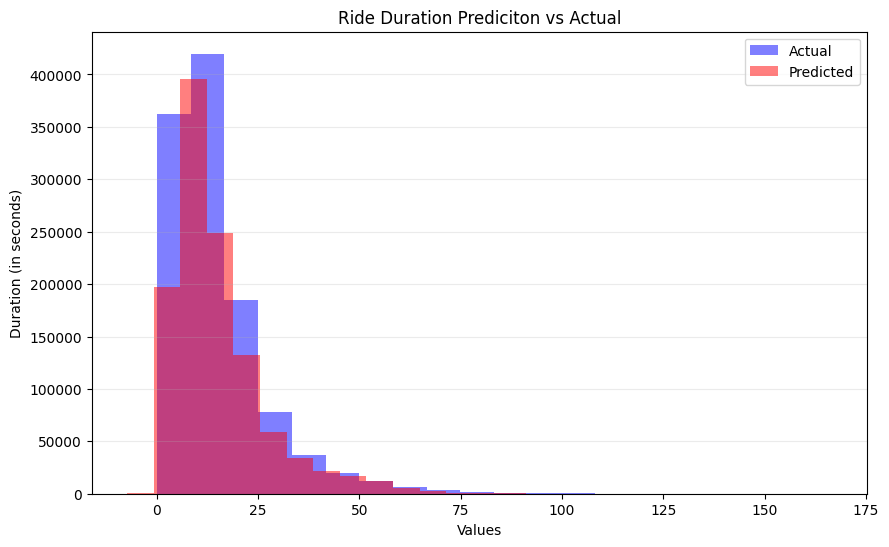

In [55]:
# Plot histograms for y_test and y_pred (overlaid)
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=20, alpha=0.5, color='blue', label='Actual')
plt.hist(y_pred, bins=20, alpha=0.5, color='red', label='Predicted')

# Add labels, title, and legend
plt.xlabel('Values')
plt.ylabel('Duration (in seconds)')
plt.title('Ride Duration Prediciton vs Actual')
plt.legend()

plt.grid(axis='y', alpha=0.25)  # Add a subtle grid for readability
plt.show()